# Run cells from AllenDB

In [ ]:
!pip install --upgrade numpy==1.24.4 pandas==2.2.2 scipy==1.11.3> /dev/null 2>&1

import os
os.kill(os.getpid(), 9)#restart so the above packages can be used

#after the above cell has restarted the session, run all below

#choose specimen id and model type

In [1]:
# Mouse L2/3 SST (Som) cell
# http://celltypes.brain-map.org/mouse/experiment/electrophysiology/476686112
specimen_id = 476686112
model_type = 'perisomatic'#or 'all active'
work_dir = 'OriginalFromAllenDB'

In [2]:
# If running in Colab
!pip install --upgrade pip2 > /dev/null 2>&1
!pip install --quiet allensdk neuron > /dev/null 2>&1
!git clone -b release_candidate https://github.com/V-Marco/ACT.git > /dev/null 2>&1

In [3]:
from allensdk.model.biophys_sim.config import Config
from allensdk.model.biophysical.utils import Utils
import os
import json
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append("ACT")
from act.passive import ACTPassiveModule

In [4]:
!pip install --quiet allensdk neuron

In [5]:
from allensdk.api.queries.biophysical_api import BiophysicalApi
from allensdk.model.biophys_sim.config import Config
from allensdk.model.biophysical.utils import Utils

#Download the cell -  if using HOC: upload the hoc template to the working directory and modfiles into a folder named 'modfiles' and skip to 'Build the Cell' then 'Simulation Parameters'

#Also if using hoc, double check parameters every time build_cell() is used

In [6]:
#get the model id

bp = BiophysicalApi()#using AllenDB's API
models = bp.get_neuronal_models(specimen_id)

for model in models:
  if model_type in model['name'].lower():
    print(f"model id = {model['id']}\n")
    model_id = model['id']
models

model id = 477878284



[{'id': 477878284,
  'name': 'Biophysical - perisomatic_Sst-IRES-Cre;Ai14-188740.03.02.01',
  'neuron_reconstruction_id': 491119369,
  'neuronal_model_template_id': 329230710,
  'specimen_id': 476686112},
 {'id': 497232660,
  'name': 'Biophysical - all active_Sst-IRES-Cre;Ai14-188740.03.02.01',
  'neuron_reconstruction_id': 491119369,
  'neuronal_model_template_id': 491455321,
  'specimen_id': 476686112}]

In [7]:
# Download the cell
bp.cache_stimulus = False # Change to False to not download the large stimulus NWB file
bp.cache_data(model_id, working_directory = work_dir )
os.chdir(work_dir)

2025-05-20 18:29:15,344 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/657210401
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/657210401
2025-05-20 18:29:15,924 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/657210404
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/657210404
2025-05-20 18:29:16,083 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/395337293
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/395337293
2025-05-20 18:29:16,243 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_fi

## Build the cell

add vecstim, cpampain.mod,NMDAIN.mod from https://github.com/yzerlaut/pv-sst-dendrites/tree/main/detailed_model and compile

In [8]:
# Compile the modfiles
!nrnivmodl modfiles > /dev/null 2>&1

In [9]:
import sys, os
from functools import wraps

def suppress_output(fn):
    @wraps(fn)
    def wrapper(*args, **kwargs):
        devnull = open(os.devnull, 'w')
        old_stdout, old_stderr = sys.stdout, sys.stderr
        sys.stdout = sys.stderr = devnull
        try:
            return fn(*args, **kwargs)
        finally:
            sys.stdout, sys.stderr = old_stdout, old_stderr
            devnull.close()
    return wrapper

**NOTE:** Control the soma area in the `build_cell` function below.

In [10]:
@suppress_output
def build_cell(soma_diam_multiplier = 1,using_hoc=False,hoc_filename=None,cell_name=None):

    if using_hoc:
      from neuron import h
      h.load_file(hoc_filename)
      return getattr(h, cell_name)()
    # Create the h object
    description = Config().load('manifest.json')
    utils = Utils(description)
    h = utils.h
    # Convert all "value" attributes to floats
    for dict in utils.description.data['genome']:
        for key, value in dict.items():
            if key == 'value': dict[key] = float(value)
    # Configure morphology
    morphology_path = description.manifest.get_path('MORPHOLOGY')
    utils.generate_morphology(morphology_path.encode('ascii', 'ignore'))
    utils.load_cell_parameters()
    # To match PP
    h.soma[0].diam = h.soma[0].diam * soma_diam_multiplier

    return h

def set_simulation(hoc_object,sim_params, soma_diam_multiplier = 1.0):
    from neuron import h
    h.load_file("stdrun.hoc")
    stim = h.IClamp(hoc_object.soma[0](0.5))
    stim.amp = sim_params['stim_amp']
    stim.delay = sim_params['stim_delay']
    stim.dur = sim_params['stim_dur']
    h.tstop = sim_params['h_tstop']
    h.dt = sim_params['h_dt']
    # h.steps_per_ms = 1 / h.dt
    return h, stim

In [11]:

soma_diam_multiplier = 1
hobject = build_cell(soma_diam_multiplier)
#hobject = build_cell(soma_diam_multiplier,using_hoc=True,'HYPO_TEMPLATE.hoc','HYPO')

#Morphology

In [12]:
print(f"Soma area: {hobject.soma[0](0.5).area()}")
print(f"Soma diam: {hobject.soma[0].diam}")
print(f"Soma L: {hobject.soma[0].L}")

Soma area: 503.6323076932052
Soma diam: 12.661399841308594
Soma L: 12.661407470703125


## Passive properties

In [13]:
# Soma area from the previous cell
computed_soma_area = hobject.soma[0](0.5).area() * 1e-8 #(cm2)
# User-provided desired properties
user_provided_Rin = 195.4 * 10e6 # (to Ohm from MOhm)
user_provided_tau = 15.6 * 1e-3 # (to s from ms)
user_provided_Vrest = -71 # (mV)
spps = ACTPassiveModule.compute_spp(user_provided_Rin, computed_soma_area, user_provided_tau, user_provided_Vrest)
print(spps)

SettablePassiveProperties(Cm=1.5852087355778763, g_bar_leak=0.00010161594458832541, e_rev_leak=-71, g_bar_h=None)


#programmatically change the json or change manually

if using a hoc file, there is no _fit.json so ignore this section

In [14]:
### Change gpas, cm, e_pas

import json

for item in os.listdir():
  if item.endswith('_fit.json'):
    config_filename = item
    print(config_filename)

with open(os.path.join(config_filename),'r') as file:
    data = json.load(file)

#save the original data
original_fit = {
                'cm':None,
                'g_pas':None,
                'e_pas':None
                }
# data in the passive section
for item in data['passive'][0]['cm']:
  original_fit['cm'] = item['cm']

original_fit['e_pas'] = data['passive'][0]['e_pas']


# data in the active "genome" section
for item in data['genome']:

  if item['name'] == 'g_pas':
    original_fit['g_pas'] = item['value']

  if item['name'] == 'cm':
    original_fit['cm'] = item['value']


#set new parameters
new_fit = {
            'cm':spps.Cm,
            'g_pas':spps.g_bar_leak,
            'e_pas':spps.e_rev_leak
            }


476686112_fit.json


choose the spp numbers or the original

In [15]:

#choose new_fit or original_fit for the _fit.json file
###############################
chosen_fit = original_fit
###############################
for item in data['passive'][0]['cm']:
  item['cm'] = chosen_fit['cm']

data['passive'][0]['e_pas'] = chosen_fit['e_pas']

for item in data['genome']:

  if item['name'] == 'g_pas':
    item['value'] = chosen_fit['g_pas']

  if item['name'] == 'cm':
    item['value'] = chosen_fit['cm']

with open(config_filename, 'w') as file:
    json.dump(data, file, indent=4)

#set simulation parameters

In [16]:
sim_params = {
                'stim_amp': -0.1,
                'stim_delay': 100,
                'stim_dur': 1000,
                'h_tstop': 1200,
                'h_dt': 0.025
                }


#run the simulation

In [17]:
def count_voltage_events(t, v):
    """
    Counts the number of times the voltage goes above -20 mV and the slope changes from positive to negative.

    Args:
        t: A NumPy array of time points.
        v: A NumPy array of voltage values.

    Returns:
        The number of events.
    """

    # Calculate the slope of the voltage
    slope = np.diff(v)

    # Find the indices where the voltage is above -20 mV
    above_threshold_indices = np.where(v[:-1] > -20)[0]

    # Find the indices where the slope changes from positive to negative
    positive_to_negative_indices = np.where((slope[:-1] > 0) & (slope[1:] < 0))[0]

    # Find the intersection of the two sets of indices
    event_indices = np.intersect1d(above_threshold_indices, positive_to_negative_indices)

    return len(event_indices)

In [18]:
#function to get the start and end index of the stim but in the voltage file
def get_start_end_idx(sim_params):
  start_idx = int(sim_params['stim_delay']/sim_params['h_dt'])
  end_idx = int(sim_params['stim_dur']/sim_params['h_dt'])
  return start_idx, end_idx

In [19]:
#function to calculate the frequency of a voltage trace
def get_frequency(v,sim_params):

  start_idx,end_idx = get_start_end_idx(sim_params)
  spikes = count_voltage_events(np.arange(len(v.as_numpy()))[start_idx:end_idx], v.as_numpy()[start_idx:end_idx])

  if spikes> 0:
    duration_sec = sim_params['stim_dur'] / 1000.0
    freq = spikes / duration_sec
    return freq

  else:
    return 0

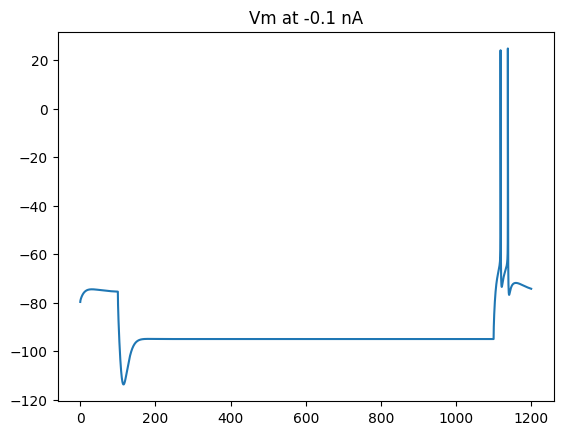

spike frequency = 0.00 Hz


In [26]:
#modify simulation parameters if needed
sim_params['stim_amp'] = -0.1

#rebuild the cell to make sure the set_simulation() is using the correct hobj
#if using hoc call with the hoc filename and cell name

soma_diam_multiplier = 1
hobject = build_cell(soma_diam_multiplier)
#hobject = build_cell(soma_diam_multiplier,using_hoc=True,'HYPO_TEMPLATE.hoc','HYPO')

# run the simulation
h, stim = set_simulation(hobject,sim_params)
v = h.Vector().record(hobject.soma[0](0.5)._ref_v)
h.finitialize()
h.run()

#plot the result and display spike frequency
V = v.as_numpy()
T = np.arange(0,h.tstop+h.dt,h.dt)
plt.plot(T,V)
plt.title(f"Vm at {sim_params['stim_amp']} nA")
plt.show()

print(f"spike frequency = {get_frequency(v,sim_params):.2f} Hz")

In [21]:
#find Rin, tau, sag ratio, and Vrest

print(ACTPassiveModule.compute_gpp(v.as_numpy(), h.dt, sim_params['stim_delay'], h.tstop, sim_params['stim_amp']))
print(f"V-rest: {v.as_numpy()[sim_params['stim_dur']]}")

GettablePassiveProperties(R_in=382.62598661561, tau1=5.25, tau2=985.6, sag_ratio=1.0312181869533368, V_rest=-75.41441453736219)
V-rest: -74.5088917566259


## FI-Curve

In [22]:
#test the cell at multiple frequencies to get an FI curve

frequenies = []
amps = [-0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]


for amp in amps:
  #if using hoc call with the hoc filename and cell name
    hobject = build_cell(soma_diam_multiplier)
    #hobject = build_cell(soma_diam_multiplier,using_hoc=True,'HYPO_TEMPLATE.hoc','HYPO')

    sim_params['stim_amp'] = amp
    h, stim = set_simulation(hobject,sim_params)
    v = h.Vector().record(hobject.soma[0](0.5)._ref_v)
    h.finitialize()
    h.run()
    frequenies.append(get_frequency(v,sim_params))


In [23]:
for a, f in zip(amps, frequenies):
    print(f"{a}: {f}")

-0.1: 0
-0.05: 0
0: 0
0.05: 90.0
0.1: 141.0
0.15: 179.0
0.2: 3.0
0.25: 2.0
0.3: 2.0


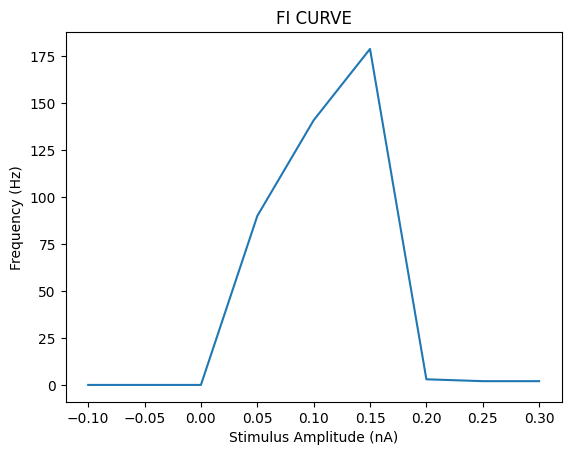

In [24]:

plt.plot(amps, frequenies)
plt.title("FI CURVE")
plt.xlabel("Stimulus Amplitude (nA)")
plt.ylabel("Frequency (Hz)")
plt.show()

#Add synapses

add single synapse first

In [ ]:
# h.CPGLUIN(x, sec=cell.SEGMENTS['NEURON_section'][syn]))
syn = h.CPGLUIN(0.5, sec=hobject.soma[0])


In [ ]:
# ampaNETCONS.append(h.NetCon(VECSTIMS[-1], AMPAS[-1]))
ampaNETCON = h.NetCon(h.VecStim(),syn)

In [ ]:
def add_synaptic_input(cell, synapses,
                       with_NMDA=False,
                       Nmax_release = 1,
                       boost_AMPA_for_SST_noNMDA=True,
                       Inh_fraction=20./100.,
                       seed=None):
    """
    add AMPA, NMDA and GABA synapses to a given cell

    if Nmax>1
    it adds other synapses with double (Nmax>=2), triple (Nmax>=3), ...
        vesicular synaptic release only on AMPA and NMDA !

    """
    if seed is None:
        seed = np.random.randint(1000)
    np.random.seed(seed)

    AMPAS, NMDAS, GABAS = [], [], []
    ampaNETCONS, nmdaNETCONS, gabaNETCONS = [], [], []
    STIMS, VECSTIMS = [], []

    excitatory = np.random.choice([True, False],
                                  len(synapses),
                                  p=[1.-Inh_fraction, Inh_fraction])

    for nVesicles in range(1, Nmax_release+1):

        for i, syn in enumerate(synapses):

            VECSTIMS.append(h.VecStim())

            # need to avoid x=0 and x=1, to allow ion concentrations variations in NEURON
            x = np.clip(cell.SEGMENTS['NEURON_segment'][syn],
                    1, cell.SEGMENTS['NEURON_section'][syn].nseg-2)\
                            /cell.SEGMENTS['NEURON_section'][syn].nseg

            if excitatory[i]:
                # excitatory synapses

                AMPAS.append(\
                        h.CPGLUIN(x, sec=cell.SEGMENTS['NEURON_section'][syn]))

                if with_NMDA:
                    NMDAS.append(\
                            h.NMDAIN(x, sec=cell.SEGMENTS['NEURON_section'][syn]))

                ampaNETCONS.append(h.NetCon(VECSTIMS[-1], AMPAS[-1]))
                if (cell.params_key=='MC') and (not with_NMDA)\
                        and boost_AMPA_for_SST_noNMDA:
                    # boosted ampa weight
                    ampaNETCONS[-1].weight[0] = cell.params['%s_qAMPA'%cell.params_key]*\
                                    cell.params['%s_qAMPAonlyBoost'%cell.params_key]*\
                                    nVesicles
                else:
                    # regular ampa weight
                    ampaNETCONS[-1].weight[0] = cell.params['%s_qAMPA'%cell.params_key]*\
                                                    nVesicles

                if with_NMDA:
                    nmdaNETCONS.append(h.NetCon(VECSTIMS[-1], NMDAS[-1]))
                    nmdaNETCONS[-1].weight[0] = cell.params['%s_NAR'%cell.params_key]*\
                                                    cell.params['%s_qAMPA'%cell.params_key]*\
                                                    nVesicles

                GABAS.append(None)
                gabaNETCONS.append(None)

            elif nVesicles==1:
                # inhibitory synapses

                GABAS.append(\
                        h.GABAain(x, sec=cell.SEGMENTS['NEURON_section'][syn]))

                gabaNETCONS.append(h.NetCon(VECSTIMS[-1], GABAS[-1]))
                gabaNETCONS[-1].weight[0] = cell.params['%s_qGABA'%cell.params_key]

                AMPAS.append(None)
                NMDAS.append(None)
                ampaNETCONS.append(None)
                nmdaNETCONS.append(None)

            else:
                # nothing, no multi-vesicular of GABAergic synapses
                GABAS.append(None)
                gabaNETCONS.append(None)
                AMPAS.append(None)
                NMDAS.append(None)
                ampaNETCONS.append(None)
                nmdaNETCONS.append(None)

    return AMPAS, NMDAS, GABAS,\
            ampaNETCONS, nmdaNETCONS, gabaNETCONS,\
            STIMS, VECSTIMS, excitatory